# Segmentez les comportements des clients - Modélisation

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [CARACTERISTIQUES](#CARACTERISTIQUES)
* [MODELISATION](#MODELISATION)
    * [KMeans](#KMeans)
        * [Cross validation](#Cross-validation)
    * [DBScan](#DBScan)
    * [Multiclass SVM](#Multiclass-SVM)
    * [Naive Bayes](#Naive-Bayes)
    * [XGBoost](#XGBoost)

# PREPARATION

## Import des librairies

In [2]:
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches

import pandas as pd
import seaborn as sns
import joblib
import datetime
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import cluster, metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn import svm
from sklearn import multiclass

## Paramétrage du notebook

In [3]:
sns.set(font='Franklin Gothic Book',rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()

pd.set_option('display.min_rows', 15)

## Declaration des fonctions

In [4]:
def profil(df):
    """
    Fonction qui retourne le profil des données d'un dataframe (moyenne, ecart type, min, max, valeurs manquantes, valeurs uniques)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données

    Returns
    -------
    result : DataFrame
        un DataFrame de profil, contenant un résumé statistique des données
    """
    
    dfValeursManquantes=pd.concat([df.isna().sum(),100*df.isna().sum()/len(df)],axis=1,keys=["missing_values","%_missing_values"])
    dfTypes=pd.DataFrame({'type':df.dtypes})
    result=df.describe(include='all',datetime_is_numeric=True).T
    result=result.merge(dfTypes,left_index=True,right_index=True)
    result=result.merge(dfValeursManquantes,left_index=True,right_index=True)
    return result

def summarizeFrequenciesDf(df,threshold):
    """
    Fonction mode qui agrege les variables qui sont sous un seuil 'threshold'(pour les très gros dataframe qui ont du mal à plotter)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données
    threshold: Int
        seuil au dessous duquel le comptage des observations sont agrégées dans la catégorie 'autres'

    Returns
    -------
    result : DataFrame
        un DataFrame contenant le comptage des observations au dessus du seuil et tout le reste dans la catégorie 'Autres'
    """

    dfFrequencies=df.value_counts()
    dfNormalizedFrequencies=df.value_counts(normalize=True) # frequence normalisée des valeurs de chaque variable
    mask = dfNormalizedFrequencies>threshold # masque sur les fréquences > seuil
    dfTail= dfFrequencies.loc[~mask].sum()
    dfFrequencies=dfFrequencies.loc[mask] # filtre sur les fréquences < seuil
    dfFrequencies['Autres']=dfTail # ajout des fréquences > seuil agregées dans la categorie 'Autre'
    return pd.DataFrame(dfFrequencies)

def plotCategoricalDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables categorielles d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures

    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCategorical=df.select_dtypes(include=['object','string', 'category'])
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))

    # Titre
    fig.suptitle("Distribution Variables Categorielles", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)
    
    i=0
    for x in dfCategorical.columns:
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)
        
        # On classe dans la categorie "Autres" les variables sous le seuil de 0,5% de frequence d'observation,
        dfCurrent=summarizeFrequenciesDf(dfCategorical[x],0.005)
    
        axes[i].bar(dfCurrent[x].index,dfCurrent[x],color='#ee6352')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#3fa7d6')
    
        i=i+1
    plt.show()
        
def plotQuantitativeDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])
    dfQSkew=dfQuantitative.skew(skipna = True).to_frame('SKEW')
    dfQColumnsSorted=dfQSkew.sort_values(by='SKEW',ascending=False).T.columns #tri des colonnes par valeur de skew

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))
    
    # Titre
    fig.suptitle("Distribution Variables Quantitatives", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)
    
    dfQuantitative
    i=0
    for x in dfQColumnsSorted:
        #dfCurrent=dfNumerical[x].sample(1000,replace=True).sort_index() #optimisation pour les large datasets
        dfCurrent=dfQuantitative[x].dropna(axis=0)
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)    
        
        axes[i].hist(dfCurrent,color='#3fa7d6')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#ee6352')
    
        i=i+1
    plt.show()
    
def maskOutliers(s):
    """
    Fonction qui retourne le mask qui retourne les lignes d'une Serie, correspondant aux outliers

    Parameters
    ----------
    s : pandas Series
        une Serie de valeurs numériques

    Returns
    -------
    mask : Series
        une Serie de booleens correspondant au masque qui retourne les valeurs atypiques/Outliers
    """
    # premier Quantile
    Q1 = s.quantile(0.25)
    # 3e quantile
    Q3 = s.quantile(0.75)
    # Interquantile
    IQR = Q3 - Q1
    
    # les outliers sont toutes les valeurs qui sont inférieures à Q1-1.5*IQR et supérieure à  Q3+1.5*IQR
    mask=(s < (Q1 - 1.5 * IQR)) |(s > (Q3 + 1.5 * IQR))
    return mask

def plotCorrelationHeatmap(plt,df):
    """
    Fonction affiche la heatmap des correlation d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCorr=df.corr()
    plt.rcParams["figure.figsize"] = (10,10)
    plt.matshow(dfCorr,cmap='coolwarm',interpolation='nearest')
    plt.xticks(range(len(dfCorr.columns)), dfCorr.columns, size='small',rotation='vertical');
    plt.yticks(range(len(dfCorr.columns)), dfCorr.columns, size='small');
    plt.show()
    
def plotBoxes(plt,df,nrows,ncols):
    """
    Fonction affiche les boites à moustache des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage
    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,20))
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)


    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    i=0
    for x in dfQuantitative.columns:
            axes[i].boxplot(dfQuantitative[x].dropna())
            axes[i].set_title(x,color='#3fa7d6')
            i+=1
    plt.show()

def plot_barh(data, title=None, fig_width=None, color='#43aa8b', fmt='.0f'):
    """Horizontal barplot for a Series
    """

    if not fig_width:
        fig_width = 12
    
    figsize = (fig_width, 0.4 * data.shape[0])

    fig, ax = plt.subplots(figsize=figsize)
    data.plot.barh(ax=ax, color=color)
    plt.gca().invert_yaxis()

    if not title and hasattr(data, "name"):
        title = data.name

    if title:
        ax.set_title(title, fontweight='bold')    

    ax.xaxis.tick_top()
    ax.yaxis.grid(False)

    width_in_pix = figsize[0] * fig.get_dpi()
    width_in_val = max(data.values)

    N_PIXELS_OFFSET = 2
    offset = N_PIXELS_OFFSET * width_in_val / width_in_pix

    for i, val in enumerate(data.values):
        ax.text(
            val + offset, i, format(val, fmt), 
            color=color, fontweight='bold', va='center'
        )

    return ax

def confusionMatrixAcc(y_true, y_pred):
    """
    Fonction qui retourne la matrice de confusion

    Parameters
    ----------
    y_true : pandas Series
        une Serie de valeurs (labels) reelles
    y_pred : pandas Series
        une Serie de valeurs (labels) predites
    Returns
    -------
    confusionMatrix : DataFrame
        la matrice de confusion
    """

    dfConfusion=pd.crosstab(y_true, y_pred,rownames=['Reel'], colnames=['Predit'], margins=False)
    #dfConfusion.drop(8,axis=1,inplace=True)
    confusionMatrix=pd.DataFrame()
    
    for c in dfConfusion.columns:
        TP=dfConfusion.iloc[c][c]
        FP=dfConfusion.iloc[c].drop(c).to_numpy().sum()
        TN=np.diagonal(dfConfusion.drop(c,axis=1).drop(c,axis=0)).sum()
        FN=dfConfusion[c].drop(c,axis=0).to_numpy().sum()
        TPR=TP/(TP+FN) # taux de vrai positif
        FPR=FP/(FP+TN) # taux de faux positifs
        Accuracy=(TP+TN)/(TP+FP+TN+FN)
        confusionMatrix=pd.concat([confusionMatrix,
        pd.DataFrame({
            'Class':[c],
            'TP':[TP],
            'FP':[FP],
            'TN':[TN],
            'FN':[FN],
            'TPR':[TPR],
            'FPR':[FPR],
            'Accuracy':[Accuracy]})
            ])
    
    confusionMatrix.reset_index(drop=True,inplace=True)
    confusionMatrix=confusionMatrix.sort_values('Accuracy',ascending=False)
    return confusionMatrix

# CHARGEMENT

In [5]:
#df=pd.read_excel("OnlineRetail.xlsx", engine='openpyxl')

In [6]:
#joblib.dump(df,"dfOnlineRetail.jbl.bz2")

In [7]:
#df=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
df=joblib.load('dfCleaned.jbl.bz2')

In [8]:
#dfRFMc=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/dfRFMc.jbl.bz2')
dfRFMc=joblib.load('dfRFMc.jbl.bz2')
dfRFMc.reset_index(inplace=True)

# CARACTERISTIQUES

## Profil

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392689 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392689 non-null  object        
 1   StockCode          392689 non-null  object        
 2   Description        392689 non-null  object        
 3   Quantity           392689 non-null  int64         
 4   InvoiceDate        392689 non-null  datetime64[ns]
 5   UnitPrice          392689 non-null  float64       
 6   CustomerID         392689 non-null  float64       
 7   Country            392689 non-null  object        
 8   TotalPrice         392689 non-null  float64       
 9   Year               392689 non-null  object        
 10  Month              392689 non-null  object        
 11  InvoiceDateSimple  392689 non-null  object        
 12  InvoiceDateYM      392689 non-null  object        
 13  CountryGroup       392689 non-null  object  

In [10]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,InvoiceDateSimple,InvoiceDateYM,CountryGroup
535302,581196,20685,DOORMAT RED RETROSPOT,2,2011-12-07 17:25:00,8.25,12935.0,United Kingdom,16.5,2011,12,2011-12-07,2011-12,UK
467396,576339,84970S,HANGING HEART ZINC T-LIGHT HOLDER,15,2011-11-14 15:27:00,2.08,14096.0,United Kingdom,31.2,2011,11,2011-11-14,2011-11,UK
357222,568069,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-09-23 14:05:00,2.10,13336.0,United Kingdom,12.6,2011,09,2011-09-23,2011-09,UK
253947,559204,21936,RED RETROSPOT PICNIC BAG,100,2011-07-07 11:02:00,2.55,13798.0,United Kingdom,255.0,2011,07,2011-07-07,2011-07,UK
120614,546667,22241,GARLAND WOODEN HAPPY EASTER,12,2011-03-15 15:31:00,1.25,14735.0,United Kingdom,15.0,2011,03,2011-03-15,2011-03,UK


In [11]:
dfProfil=profil(df)
dfProfil

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,type,missing_values,%_missing_values
InvoiceNo,392689,18529,576339,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
StockCode,392689,3665,85123A,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
Description,392689,3877,WHITE HANGING HEART T-LIGHT HOLDER,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
Quantity,392689.0,NaN,NaN,NaN,13.152716,1.0,2.0,6.0,12.0,80995.0,181.596931,int64,0,0.0
InvoiceDate,392689,NaN,NaN,NaN,2011-07-10 19:19:07.882420736,2010-12-01 08:26:00,2011-04-07 11:16:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN,datetime64[ns],0,0.0
UnitPrice,392689.0,NaN,NaN,NaN,3.093796,0.0,1.25,1.95,3.75,8142.75,20.565579,float64,0,0.0
CustomerID,392689.0,NaN,NaN,NaN,15287.863671,12346.0,13955.0,15150.0,16791.0,18287.0,1713.519206,float64,0,0.0
Country,392689,37,United Kingdom,349198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
TotalPrice,392689.0,NaN,NaN,NaN,22.595468,0.0,4.95,12.39,19.8,168469.6,310.984565,float64,0,0.0
Year,392689,2,2011,367026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0


## Segments

In [12]:
dfRFMc

,CustomerID,Country,CountryGroup,Recence,Frequence,Montant,Frequence7
0,14911.0,EIRE,Europe,0,5672,143711.17,3.782258
1,12748.0,United Kingdom,UK,0,4409,33014.24,3.941019
2,14606.0,United Kingdom,UK,0,2677,12076.15,1.750000
3,15311.0,United Kingdom,UK,0,2366,60632.75,1.707775
4,13263.0,United Kingdom,UK,0,1667,7436.93,0.756173
5,14796.0,United Kingdom,UK,0,1132,7975.49,0.325137
6,14056.0,United Kingdom,UK,0,1088,8152.71,0.568905
...,...,...,...,...,...,...,...
4332,17968.0,United Kingdom,UK,373,81,265.10,0.018767
4333,14729.0,United Kingdom,UK,373,71,313.49,0.018767


La loi de Pareto enonce qu'environ 80 % des effets sont le produit de 20 % des causes.  
Nous utilisons ce principe pour ne considérer comme significatif (score = 2) que le premier quantile de 20% et ignorer les 80% restants (score = 1).

In [13]:
# pour la frequence et le montant, le quantile de 80% correspond au seuil en dessous duquel la fréquence et le montant ne sont pas significatifs (score = 1)
quantilesPareto = dfRFMc.quantile(q=[0.8])
quantilesPareto['Recence']=dfRFMc['Recence'].quantile(q=0.2) #la recence la plus faible correspond au score le plus elevé (score = 2)
quantilesPareto

,CustomerID,Recence,Frequence,Montant,Frequence7
0.8,17080.4,12.6,120.0,2053.556,0.228645


In [14]:
# Matrice de valeur
dfRFMc['RScore']=np.where(dfRFMc['Recence']<=quantilesPareto['Recence'].iloc[0],2,1)
dfRFMc['FScore']=np.where(dfRFMc['Frequence']>=quantilesPareto['Frequence'].iloc[0],2,1)
dfRFMc['MScore']=np.where(dfRFMc['Montant']>=quantilesPareto['Montant'].iloc[0],2,1)
dfRFMc['RFMScore']=dfRFMc['RScore'].map(str)+dfRFMc['FScore'].map(str)+dfRFMc['MScore'].map(str)
dfRFMc.sort_values('RFMScore',ascending=False)

,CustomerID,Country,CountryGroup,Recence,Frequence,Montant,Frequence7,RScore,FScore,MScore,RFMScore
0,14911.0,EIRE,Europe,0,5672,143711.17,3.782258,2,2,2,222
593,14659.0,United Kingdom,UK,8,253,2529.93,0.200000,2,2,2,222
583,15993.0,United Kingdom,UK,8,543,2777.67,1.139535,2,2,2,222
585,16712.0,United Kingdom,UK,8,438,3611.31,0.280000,2,2,2,222
586,14713.0,United Kingdom,UK,8,338,2662.20,0.211538,2,2,2,222
588,16700.0,United Kingdom,UK,8,308,5076.55,0.249315,2,2,2,222
589,16839.0,United Kingdom,UK,8,266,16594.35,0.644986,2,2,2,222
...,...,...,...,...,...,...,...,...,...,...,...
2281,15826.0,United Kingdom,UK,55,68,1654.31,0.100000,1,1,1,111
2282,17892.0,United Kingdom,UK,55,28,244.10,0.136364,1,1,1,111


In [15]:
dfRFMc['RFMScore'].unique()

array(['222', '221', '211', '212', '121', '122', '112', '111'],
      dtype=object)

In [16]:
# Aggregation par score RFM
dfRFMc_sum= dfRFMc.groupby('RFMScore').agg({
    'CustomerID': lambda x: len(x.unique()),
    'Recence': lambda x: round(x.mean(),0),
    'Frequence': lambda x: round(x.mean(),0),
    'Montant': lambda x: round(x.mean(),0),
    'RScore': lambda x: round(x.mean(),0),
    'FScore': lambda x: round(x.mean(),0),
    'MScore': lambda x: round(x.mean(),0)})
dfRFMc_sum.reset_index(inplace=True)
dfRFMc_sum.sort_values('RFMScore',ascending=False)

,RFMScore,CustomerID,Recence,Frequence,Montant,RScore,FScore,MScore
7,222,309,4.0,438.0,11574.0,2.0,2.0,2.0
6,221,94,6.0,213.0,1291.0,2.0,2.0,1.0
5,212,87,6.0,80.0,7451.0,2.0,1.0,2.0
4,211,378,6.0,48.0,813.0,2.0,1.0,1.0
3,122,297,45.0,248.0,5333.0,1.0,2.0,2.0
2,121,170,60.0,182.0,1191.0,1.0,2.0,1.0
1,112,175,70.0,73.0,4657.0,1.0,1.0,2.0
0,111,2829,126.0,34.0,572.0,1.0,1.0,1.0


In [17]:
# Nommer les groupes
# Les Clients Fidèles, qui sont les champions de tous les clients avec le meilleur score de RFM
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='222','Group']='champion'

# Les clients loyaux. Ils achètent quasi aussi récemment et fréquemment que les champions. Le montant qu'ils ont dépensé est moins important que les champions
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='221','Group']='loyal'

# Les clients qui ont le plus de potentiel pour devenir les Champions. Ils achètent pas récemment les produits et font leurs achats assez fréquemment. De plus, le montant qu'ils ont dépensé est assez important
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='212','Group']='potentiel'

# Les clients qui sont nouveaux. Ils achètent pas récemment les produits mais ne font pas leurs achats  fréquemment. De plus, le montant qu'ils ont dépensé n'est pas important
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='211','Group']='nouveau'

# Les clients qui achètent récemment les produits  et font leurs achats  fréquemment. De plus, le montant qu'ils ont dépensé est important
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='122','Group']='a ne pas perdre'

# Les clients qui achètent récemment les produits  et font leurs achats  fréquemment mais le montant qu'ils ont dépensé n'est pas important
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='121','Group']='en risque'

# Les clients qui achètent récemment les produits  et font leurs achats pas fréquemment mais le montant qu'ils ont dépensé est important
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='112','Group']='en hibernation'

# Les clients qui achètent récemment les produits  et font leurs achats pas fréquemment mais le montant qu'ils ont dépensé est important
dfRFMc_sum.loc[dfRFMc_sum['RFMScore']=='111','Group']='perdu'

dfRFMc_sum.sort_values('RFMScore',ascending=False)

,RFMScore,CustomerID,Recence,Frequence,Montant,RScore,FScore,MScore,Group
7,222,309,4.0,438.0,11574.0,2.0,2.0,2.0,champion
6,221,94,6.0,213.0,1291.0,2.0,2.0,1.0,loyal
5,212,87,6.0,80.0,7451.0,2.0,1.0,2.0,potentiel
4,211,378,6.0,48.0,813.0,2.0,1.0,1.0,nouveau
3,122,297,45.0,248.0,5333.0,1.0,2.0,2.0,a ne pas perdre
2,121,170,60.0,182.0,1191.0,1.0,2.0,1.0,en risque
1,112,175,70.0,73.0,4657.0,1.0,1.0,2.0,en hibernation
0,111,2829,126.0,34.0,572.0,1.0,1.0,1.0,perdu


In [18]:
dfRFMc[dfRFMc['RFMScore']=='222'].sort_values('CustomerID',ascending=False)

,CustomerID,Country,CountryGroup,Recence,Frequence,Montant,Frequence7,RScore,FScore,MScore,RFMScore
207,18272.0,United Kingdom,UK,2,166,3078.58,0.170732,2,2,2,222
475,18245.0,United Kingdom,UK,6,175,2567.06,0.138418,2,2,2,222
813,18229.0,United Kingdom,UK,11,164,7276.90,0.376344,2,2,2,222
194,18225.0,United Kingdom,UK,2,269,5504.96,0.230769,2,2,2,222
392,18223.0,United Kingdom,UK,4,272,6484.54,0.274510,2,2,2,222
141,18210.0,United Kingdom,UK,1,134,2621.38,0.157895,2,2,2,222
308,18198.0,United Kingdom,UK,3,159,5425.56,0.355224,2,2,2,222
...,...,...,...,...,...,...,...,...,...,...,...
102,12471.0,Germany,Europe,1,459,19788.65,0.576923,2,2,2,222
727,12451.0,Switzerland,Europe,10,354,9035.52,0.108025,2,2,2,222


findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


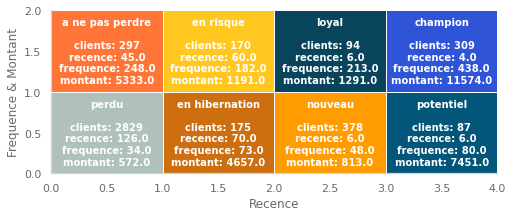

In [19]:
fig=plt.figure(figsize=(8,3))
plt.xlim([0,4])
plt.ylim([0,2])
ax=plt.gca()

width=1
height=1

# Rectangles par segment (Clients, Recence, Frequence, Montant)
rectangles = { 
    dfRFMc_sum['Group'].iloc[0] : [mpatches.Rectangle((0, 0), width, height, linewidth=1, edgecolor='white', facecolor='#b0c0bc'),dfRFMc_sum['CustomerID'][0],dfRFMc_sum['Recence'][0],dfRFMc_sum['Frequence'][0],dfRFMc_sum['Montant'][0]],
    dfRFMc_sum['Group'].iloc[1] : [mpatches.Rectangle((1, 0), width, height, linewidth=1, edgecolor='white', facecolor='#cd6e10'),dfRFMc_sum['CustomerID'][1],dfRFMc_sum['Recence'][1],dfRFMc_sum['Frequence'][1],dfRFMc_sum['Montant'][1]],
    dfRFMc_sum['Group'].iloc[2] : [mpatches.Rectangle((1, 1), width, height, linewidth=1, edgecolor='white', facecolor='#ffc71f'),dfRFMc_sum['CustomerID'][2],dfRFMc_sum['Recence'][2],dfRFMc_sum['Frequence'][2],dfRFMc_sum['Montant'][2]],
    dfRFMc_sum['Group'].iloc[3] : [mpatches.Rectangle((0, 1), width, height, linewidth=1, edgecolor='white', facecolor='#ff7538'),dfRFMc_sum['CustomerID'][3],dfRFMc_sum['Recence'][3],dfRFMc_sum['Frequence'][3],dfRFMc_sum['Montant'][3]],
    dfRFMc_sum['Group'].iloc[4] : [mpatches.Rectangle((2, 0), width, height, linewidth=1, edgecolor='white', facecolor='#ff9c00'),dfRFMc_sum['CustomerID'][4],dfRFMc_sum['Recence'][4],dfRFMc_sum['Frequence'][4],dfRFMc_sum['Montant'][4]],
    dfRFMc_sum['Group'].iloc[5] : [mpatches.Rectangle((3, 0), width, height, linewidth=1, edgecolor='white', facecolor='#02567a'),dfRFMc_sum['CustomerID'][5],dfRFMc_sum['Recence'][5],dfRFMc_sum['Frequence'][5],dfRFMc_sum['Montant'][5]],
    dfRFMc_sum['Group'].iloc[6] : [mpatches.Rectangle((2, 1), width, height, linewidth=1, edgecolor='white', facecolor='#08445c'),dfRFMc_sum['CustomerID'][6],dfRFMc_sum['Recence'][6],dfRFMc_sum['Frequence'][6],dfRFMc_sum['Montant'][6]],
    dfRFMc_sum['Group'].iloc[7] : [mpatches.Rectangle((3, 1), width, height, linewidth=1, edgecolor='white', facecolor='#2f54d8'),dfRFMc_sum['CustomerID'][7],dfRFMc_sum['Recence'][7],dfRFMc_sum['Frequence'][7],dfRFMc_sum['Montant'][7]]
}

for r in rectangles:
    ax.add_artist(rectangles[r][0])
    rx, ry = rectangles[r][0].get_xy()
    cx = rx + rectangles[r][0].get_width()/2.0
    cy = ry + rectangles[r][0].get_height()/2.0
    tc = "clients: "+str(rectangles[r][1])
    tr = "recence: "+str(rectangles[r][2])
    tf = "frequence: "+str(rectangles[r][3])
    tm = "montant: "+str(rectangles[r][4])
    ax.annotate(r+"\n\n"+tc+"\n"+tr+"\n"+tf+"\n"+tm, (cx, cy), color='w', weight='bold', fontsize=10, ha='center', va='center')

plt.xlabel('Recence')
plt.ylabel('Frequence & Montant')
plt.show()

# MODELISATION

## Preparation

In [20]:
# encodage du score RFM
le=preprocessing.LabelEncoder()
le.fit_transform(dfRFMc['RFMScore'])
mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping

{'111': 0,
 '112': 1,
 '121': 2,
 '122': 3,
 '211': 4,
 '212': 5,
 '221': 6,
 '222': 7}

In [21]:
X=dfRFMc[['Recence','Frequence','Montant']]
#X=dfRFMc[['Frequence','Montant']]
#y=dfRFMc['RFMScore']
y=dfRFMc['RFMScore'].apply(lambda x: mapping[x])
X.shape, y.shape, y

((4339, 3),
 (4339,),
 0       7
 1       7
 2       7
 3       7
 4       7
 5       7
 6       7
        ..
 4332    0
 4333    0
 4334    0
 4335    0
 4336    0
 4337    0
 4338    0
 Name: RFMScore, Length: 4339, dtype: int64)

In [22]:
# Exclusion des valeurs aberrantes
#X_std['Recence']=X[~maskOutliers(X['Recence'])]['Recence']
X_std=X.copy()
X_std['Frequence']=X_std[~maskOutliers(X['Frequence'])]['Frequence']
X_std['Recence']=X_std[~maskOutliers(X['Recence'])]['Recence']
X_std['Montant']=X_std[~maskOutliers(X['Montant'])]['Montant']

In [23]:
maskIsNA=(X_std['Recence'].isna() | X_std['Frequence'].isna() | X_std['Montant'].isna())

In [24]:
# separation du jeu de donnée d'entrainement, et de test
#X_train, X_test, y_train, y_test=train_test_split(X_normalise,y,test_size=0.3,random_state = 49)
X_train, X_test, y_train, y_test=train_test_split(X_std[~maskIsNA].values,y[~maskIsNA],test_size=0.3,random_state = 49)
#X_train, X_test=train_test_split(X_std[~maskIsNA].values,test_size=0.3,random_state = 49)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2528, 3), (1084, 3), (2528,), (1084,))

## Naive Bayes

In [25]:
MNNaiveBayes = MultinomialNB().fit(X_train, y_train)
y_pred_train=MNNaiveBayes.predict(X_train)
y_pred_test=MNNaiveBayes.predict(X_test)

In [26]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.6171586715867159, 0.32124499392377903)

In [27]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
5,5,9,2,660,20,0.310345,0.003021,0.968162
6,6,11,7,658,20,0.354839,0.010526,0.961207
7,7,14,2,655,26,0.350000,0.003044,0.959828
2,2,21,17,648,95,0.181034,0.025564,0.856594
1,1,20,11,649,103,0.162602,0.016667,0.854406
4,4,31,80,638,40,0.436620,0.111421,0.847909
3,3,11,25,658,105,0.094828,0.036603,0.837297
0,0,552,271,117,6,0.989247,0.698454,0.707188


## KNN

In [28]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=7)
classifier.fit(X_train, y_train)
y_pred_test = classifier.predict(X_test)

In [29]:
# scores exactitude, r2
accuracy = accuracy_score(y_test, y_pred_test) 
r2 = r2_score(y_test,y_pred_test)
accuracy, r2

(0.8745387453874539, 0.390313495929685)

In [30]:
dfConfusion=confusionMatrixAcc(y_test, y_pred_test)
dfConfusion

,Class,TP,FP,TN,FN,TPR,FPR,Accuracy
5,5,2,9,946,3,0.400000,0.009424,0.987500
7,7,6,10,942,7,0.461538,0.010504,0.982383
6,6,3,15,945,4,0.428571,0.015625,0.980352
3,3,23,13,925,10,0.696970,0.013859,0.976313
1,1,24,7,924,17,0.585366,0.007519,0.975309
2,2,19,19,929,8,0.703704,0.020042,0.972308
4,4,65,46,883,19,0.773810,0.049516,0.935834
0,0,806,17,142,68,0.922197,0.106918,0.917715


## DBScan

In [31]:
X_train.shape

(2528, 3)

In [32]:
dimension = 3

https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

Une technique pour déterminer la valeur optimale de epsilon est décrite dans cet article. Cette technique calcule la distance moyenne entre chaque point et ses k voisins les plus proches, où k = la valeur MinPts que vous avez sélectionnée. Les k-distances moyennes sont ensuite tracées par ordre croissant sur un graphique de k-distances. Vous trouverez la valeur optimale au point de courbure maximale

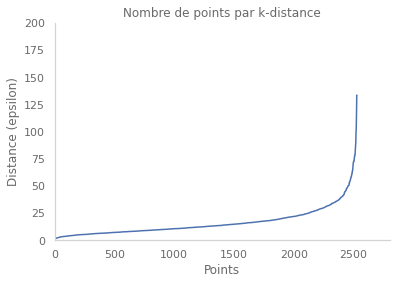

In [33]:
neighbors = NearestNeighbors(n_neighbors=(2*dimension))
neighbors_fit = neighbors.fit(X_train)
distances, indices = neighbors_fit.kneighbors(X_train)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axis([0, 2800, 0, 200])
plt.xlabel("Points")
plt.ylabel("Distance (epsilon)")
plt.title("Nombre de points par k-distance")
plt.plot(distances)
plt.show()

In [34]:
#Calcule la distance moyenne entre un ensemble de n points dans un espace à d-dimensions.
from scipy.spatial.distance import pdist
import numpy as np

mean_distance=np.mean(pdist(X_train))
mean_distance

843.7058593469392

In [35]:
dbscan=cluster.DBSCAN(eps=57,min_samples=(dimension*2),metric='euclidean')

In [36]:
dbscan.fit(X_train)
cluster_labels = dbscan.labels_

# silhouette score
silhouette_avg = metrics.silhouette_score(X_train, cluster_labels)
print(f"The silhouette score is {silhouette_avg}")

The silhouette score is 0.30743312147157476


In [37]:
# labels unique
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4,  5])

In [38]:
cmap=({
    -1:'#000000',
    0:'#EF476F', 
    1:'#F78C6B',
    2:'#FFD166',
    3:'#83D483',
    4:'#06D6A0',
    5:'#0CB0A9',
    6:'#118AB2',
    7:'#0A4C63',
    8:'#062837'
})

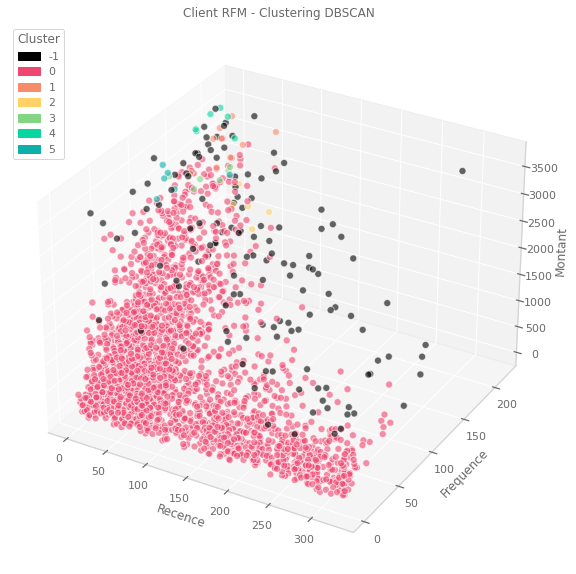

CPU times: user 704 ms, sys: 14.2 ms, total: 718 ms
Wall time: 243 ms


In [39]:
%%time
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xs = X_train[:,0]
ys = X_train[:,1]
zs = X_train[:,2]
ls=[l for l in cluster_labels]
cs= [cmap[l] for l in cluster_labels]



ax.scatter(xs, ys, zs, c=cs, s=50, alpha=0.6, edgecolors='w')

n_patch = mpatches.Patch(color=cmap[-1], label=-1)
a_patch = mpatches.Patch(color=cmap[0], label=0)
b_patch = mpatches.Patch(color=cmap[1], label=1)
c_patch = mpatches.Patch(color=cmap[2], label=2)
d_patch = mpatches.Patch(color=cmap[3], label=3)
e_patch = mpatches.Patch(color=cmap[4], label=4)
f_patch = mpatches.Patch(color=cmap[5], label=5)
g_patch = mpatches.Patch(color=cmap[6], label=6)
h_patch = mpatches.Patch(color=cmap[7], label=7)

plt.legend(title="Cluster",handles=[n_patch, a_patch, b_patch, c_patch, d_patch, e_patch, f_patch],loc="upper left")

ax.set_xlabel('Recence')
ax.set_ylabel('Frequence')
ax.set_zlabel('Montant')
plt.title('Client RFM - Clustering DBSCAN')
plt.show()

## KMeans

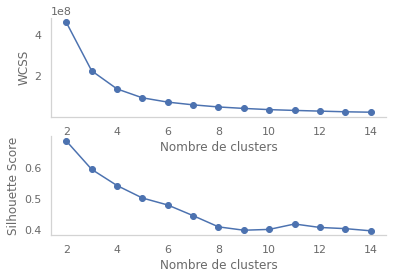

In [40]:
wcss=[] #  somme des carrés intra cluster (somme de la distance au carré entre chaque membre du cluster et son centroïde)
silhouettes=[]

for n in range(2,15):
    cl = cluster.KMeans(n_clusters=n, init='k-means++')# pour avoir une initialisation aleatoire et unique
    y_pred=cl.fit_predict(X_train)# faire le clustering sur les données normalisée et calculer le coefficient de silhouette
    #labels=cl.labels_
    centroids=cl.cluster_centers_
    wcss.append(cl.inertia_)
    
    silhouette=metrics.silhouette_score(X_train,y_pred, metric='euclidean')
    silhouettes.append(silhouette)
    
plt.subplot(2, 1, 1);
plt.plot(range(2,15), wcss, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('WCSS')

plt.subplot(2, 1, 2);
plt.plot(range(2,15), silhouettes, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Silhouette Score')
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.6844878108758536
For n_clusters = 3 The average silhouette_score is : 0.5937485300028643
For n_clusters = 4 The average silhouette_score is : 0.5420032555975153
For n_clusters = 5 The average silhouette_score is : 0.5034507289704353
For n_clusters = 6 The average silhouette_score is : 0.4814770563182914
For n_clusters = 7 The average silhouette_score is : 0.4381415825838957
For n_clusters = 8 The average silhouette_score is : 0.41353819861718266
For n_clusters = 9 The average silhouette_score is : 0.39916733930300635


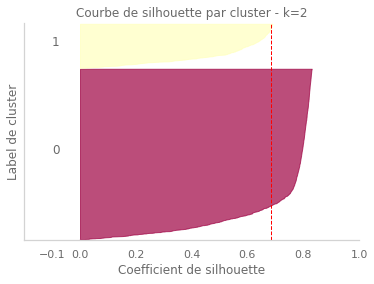

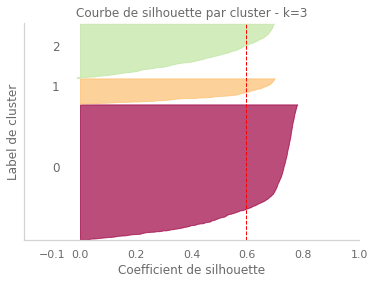

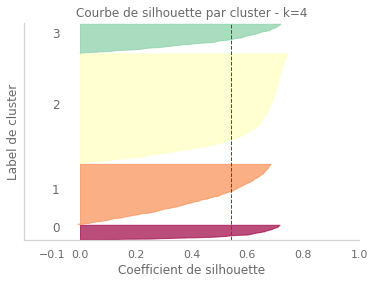

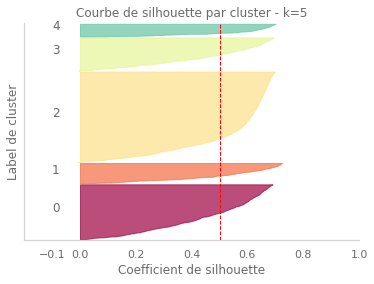

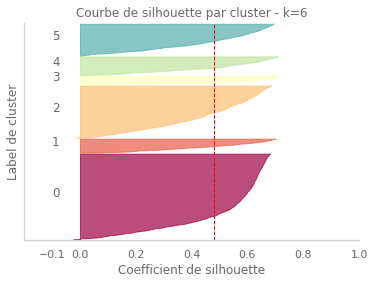

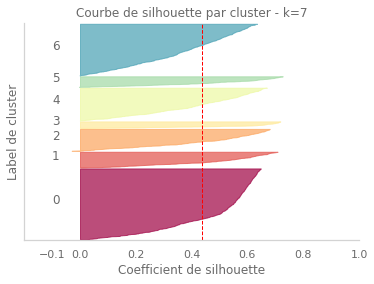

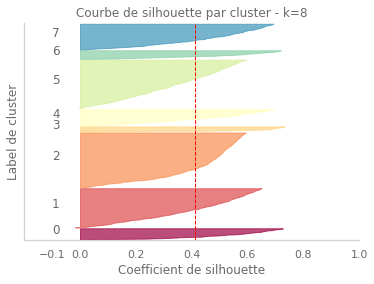

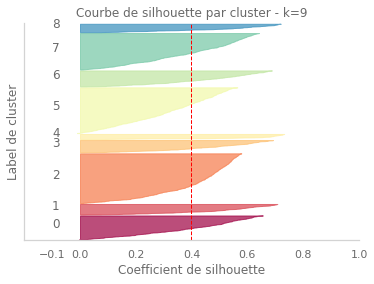

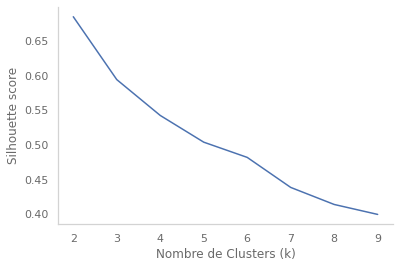

In [41]:
# Recherche du nombre optimal de clusters par courbes de silhouette

range_n_clusters = [2, 3, 4, 5, 6,7,8,9]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots()
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-1, 1]
    ax.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    cl = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = cl.fit_predict(X_train)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(X_train, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(X_train, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        y_upper = y_lower + size_cluster_i

        color = cm.Spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax.set_title("Courbe de silhouette par cluster - k="+str(n_clusters))
    ax.set_xlabel("Coefficient de silhouette")
    ax.set_ylabel("Label de cluster")
    
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--",linewidth=1)

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
plt.show()


plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Nombre de Clusters (k)")
plt.ylabel("Silhouette score")
plt.show()

Pour l'ensemble des k, le score de silhouette est faible (< à 0.7). 
on choisit donc le nombre de k le plus elevés pour le score de silhouette moyen le plus elevé, n_clusters=8.

In [42]:
cl = cluster.KMeans(n_clusters=6, init='k-means++')# pour avoir une initialisation aleatoire et unique
cl.fit(X_train)
labels=cl.labels_
centroids=cl.cluster_centers_

In [43]:
y_pred_train=cl.predict(X_train)
y_pred_train

array([3, 4, 2, ..., 0, 2, 5], dtype=int32)

In [44]:
# nombre de labels uniques
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [45]:
cmap=({
    -1:'#000000',
    0:'#EF476F', 
    1:'#F78C6B',
    2:'#FFD166',
    3:'#83D483',
    4:'#06D6A0',
    5:'#0CB0A9',
    6:'#118AB2',
    7:'#0A4C63',
    8:'#062837'
})

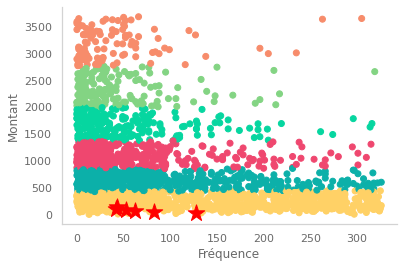

In [46]:
# visualisation du clustering kmeans
plt.scatter(X_train[:,0],X_train[:,2],c=[cmap[l] for l in y_pred_train])
# affichage des centroides
plt.scatter(centroids[:,0], centroids[:, 1],s = 300, c = 'red', label = 'Centroid', marker='*')

a_patch = mpatches.Patch(color=cmap[0], label=0)
b_patch = mpatches.Patch(color=cmap[1], label=1)
c_patch = mpatches.Patch(color=cmap[2], label=2)
d_patch = mpatches.Patch(color=cmap[3], label=3)
e_patch = mpatches.Patch(color=cmap[4], label=4)
f_patch = mpatches.Patch(color=cmap[5], label=5)
g_patch = mpatches.Patch(color=cmap[6], label=6)
h_patch = mpatches.Patch(color=cmap[7], label=7)
i_patch = mpatches.Patch(color=cmap[8], label=8)

#plt.legend(title="Cluster",handles=[a_patch, b_patch, c_patch, d_patch, e_patch, f_patch],loc="upper right")
plt.xlabel('Fréquence')
plt.ylabel('Montant')
plt.show()

Le clustering K-Means ne distingue que les classes de montant: en effet, sur l'axe des fréquence, on ne voit pas de distinction entre les couches

In [47]:
#np.unique(y_pred_train), np.unique(y_train)

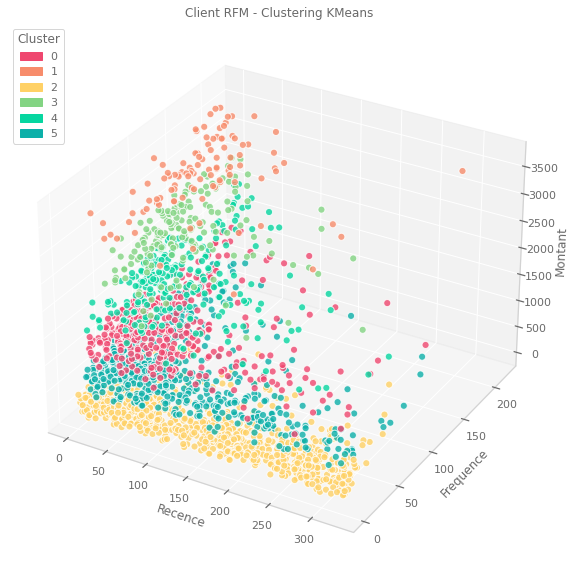

In [48]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

xs = X_train[:,0]
ys = X_train[:,1]
zs = X_train[:,2]
ls=[l for l in labels]
cs= [cmap[l] for l in labels]



ax.scatter(xs, ys, zs, c=cs, s=50, alpha=0.8, edgecolors='w')

a_patch = mpatches.Patch(color=cmap[0], label=0)
b_patch = mpatches.Patch(color=cmap[1], label=1)
c_patch = mpatches.Patch(color=cmap[2], label=2)
d_patch = mpatches.Patch(color=cmap[3], label=3)
e_patch = mpatches.Patch(color=cmap[4], label=4)
f_patch = mpatches.Patch(color=cmap[5], label=5)
g_patch = mpatches.Patch(color=cmap[6], label=6)
h_patch = mpatches.Patch(color=cmap[7], label=7)
i_patch = mpatches.Patch(color=cmap[8], label=8)

plt.legend(title="Cluster",handles=[a_patch, b_patch, c_patch, d_patch, e_patch, f_patch],loc="upper left")

ax.set_xlabel('Recence')
ax.set_ylabel('Frequence')
ax.set_zlabel('Montant')
plt.title('Client RFM - Clustering KMeans')
plt.show()

In [49]:
metrics.silhouette_score(X_train,y_pred_train, metric='euclidean')

0.47848186528383047

### Cross validation

In [50]:
dictSilhouettePeriod={}

In [51]:
#dictRFMPeriod=joblib.load('drive/MyDrive/Colab Notebooks/Datasets/dictRFMPeriod.jbl.bz2')
dictRFMPeriod=joblib.load('dictRFMPeriod.jbl.bz2')

In [52]:
dictRFMPeriod.keys()

dict_keys([0, 1, 2])

In [53]:
dictRFMPeriod[0][['Recence','Frequence','Montant']]

,Recence,Frequence,Montant
CustomerID,,,
17841.0,0,1765,10159.27
14911.0,0,1373,34294.47
13089.0,0,843,26950.98
15039.0,0,806,12217.61
18118.0,0,723,3311.73
16710.0,0,260,1628.83
15044.0,0,229,4455.73
...,...,...,...
16835.0,166,5,81.75


In [54]:
# calcul des scores R,F,M et RFM sur chacune des periodes
dictQuantilesPareto={}
for i in dictRFMPeriod.keys():
    dictQuantilesPareto[i] = dictRFMPeriod[i].quantile(q=[0.8])
    dictQuantilesPareto[i]['Recence']=dictRFMPeriod[i]['Recence'].quantile(q=0.2) #la recence la plus faible correspond au score le plus elevé
    
    dictRFMPeriod[i]['RScore']=np.where(dictRFMPeriod[i]['Recence']<=dictQuantilesPareto[i]['Recence'].iloc[0],2,1)
    dictRFMPeriod[i]['FScore']=np.where(dictRFMPeriod[i]['Frequence']>=dictQuantilesPareto[i]['Frequence'].iloc[0],2,1)
    dictRFMPeriod[i]['MScore']=np.where(dictRFMPeriod[i]['Montant']>=dictQuantilesPareto[i]['Montant'].iloc[0],2,1)
    dictRFMPeriod[i]['RFMScore']=dictRFMPeriod[i]['RScore'].map(str)+dictRFMPeriod[i]['FScore'].map(str)+dictRFMPeriod[i]['MScore'].map(str)

In [55]:
dictRFMPeriod[0]['RFMScore'].unique()

array(['222', '221', '211', '212', '122', '111', '112', '121'],
      dtype=object)

In [56]:
X0=dictRFMPeriod[0][['Recence','Frequence','Montant']]

# Exclusion des valeurs aberrantes
#X_std['Recence']=X[~maskOutliers(X['Recence'])]['Recence']
X0_std=X0.copy()
X0_std['Frequence']=X0_std[~maskOutliers(X0['Frequence'])]['Frequence']
X0_std['Recence']=X0_std[~maskOutliers(X0['Recence'])]['Recence']
X0_std['Montant']=X0_std[~maskOutliers(X0['Montant'])]['Montant']

maskIsNA0=(X0_std['Recence'].isna() | X0_std['Frequence'].isna() | X0_std['Montant'].isna())

# separation du jeu de donnée d'entrainement, et de test
#X_train, X_test, y_train, y_test=train_test_split(X_normalise,y,test_size=0.3,random_state = 49)
X0_train, X0_test=train_test_split(X0_std[~maskIsNA0].values,test_size=0.3,random_state = 49)

y0_pred_test=cl.predict(X0_test)
np.unique(y0_pred_test),X0_train.shape, X0_test.shape

(array([0, 2, 3, 4, 5], dtype=int32), (1579, 3), (678, 3))

In [57]:
dictSilhouettePeriod[0]=metrics.silhouette_score(X0_test,y0_pred_test, metric='euclidean')

In [58]:
X1=dictRFMPeriod[1][['Recence','Frequence','Montant']]

# Exclusion des valeurs aberrantes
#X_std['Recence']=X[~maskOutliers(X['Recence'])]['Recence']
X1_std=X1.copy()
X1_std['Frequence']=X1_std[~maskOutliers(X1['Frequence'])]['Frequence']
X1_std['Recence']=X1_std[~maskOutliers(X1['Recence'])]['Recence']
X1_std['Montant']=X1_std[~maskOutliers(X1['Montant'])]['Montant']

maskIsNA1=(X1_std['Recence'].isna() | X1_std['Frequence'].isna() | X1_std['Montant'].isna())

# separation du jeu de donnée d'entrainement, et de test
#X_train, X_test, y_train, y_test=train_test_split(X_normalise,y,test_size=1.3,random_state = 49)
X1_train, X1_test=train_test_split(X1_std[~maskIsNA1].values,test_size=0.3,random_state = 49)

y1_pred_test=cl.predict(X1_test)
np.unique(y1_pred_test),X1_train.shape, X1_test.shape

(array([0, 2, 3, 4, 5], dtype=int32), (1580, 3), (678, 3))

In [59]:
dictSilhouettePeriod[1]=metrics.silhouette_score(X1_test,y1_pred_test, metric='euclidean')

In [60]:
X2=dictRFMPeriod[2][['Recence','Frequence','Montant']]

# Exclusion des valeurs aberrantes
#X_std['Recence']=X[~maskOutliers(X['Recence'])]['Recence']
X2_std=X2.copy()
X2_std['Frequence']=X2_std[~maskOutliers(X2['Frequence'])]['Frequence']
X2_std['Recence']=X2_std[~maskOutliers(X2['Recence'])]['Recence']
X2_std['Montant']=X2_std[~maskOutliers(X2['Montant'])]['Montant']

maskIsNA2=(X2_std['Recence'].isna() | X2_std['Frequence'].isna() | X2_std['Montant'].isna())

# separation du jeu de donnée d'entrainement, et de test
#X_train, X_test, y_train, y_test=train_test_split(X_normalise,y,test_size=2.3,random_state = 49)
X2_train, X2_test=train_test_split(X2_std[~maskIsNA2].values,test_size=0.3,random_state = 49)

y2_pred_test=cl.predict(X2_test)
np.unique(y2_pred_test),X2_train.shape, X2_test.shape

(array([0, 2, 4, 5], dtype=int32), (1588, 3), (681, 3))

In [61]:
dictSilhouettePeriod[2]=metrics.silhouette_score(X2_test,y2_pred_test, metric='euclidean')

In [62]:
for i in dictSilhouettePeriod.keys():
    print(f"Score Silhouette[{i}]:{dictSilhouettePeriod[i]}")

Score Silhouette[0]:0.5551582932261364
Score Silhouette[1]:0.5286834271250229
Score Silhouette[2]:0.5490627042305385


le score de silhouette est proche de 0.5 pour l'ensemble des périodes